## Package import

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Data Import & Data Cleaning

In [56]:
# 1. Download data
df = pd.read_csv("/Users/haoquan/Desktop/UW/Research/WIM/25 Fall-Multitask Learning/sp500_index.csv")#.iloc[:1000,:]
# --- Ensure Date is datetime ---
df["Date"] = pd.to_datetime(df["Date"])
# Compute daily returns
df["Return"] = df["S&P500"].pct_change()
df.dropna(inplace=True)
df

,Date,S&P500,Return
1,2014-12-23,2082.17,0.001746
2,2014-12-24,2081.88,-0.000139
3,2014-12-26,2088.77,0.003310
4,2014-12-29,2090.57,0.000862
5,2014-12-30,2080.35,-0.004889
...,...,...,...
2512,2024-12-16,6074.08,0.003799
2513,2024-12-17,6050.61,-0.003864
2514,2024-12-18,5872.16,-0.029493
2515,2024-12-19,5867.08,-0.000865


# Supervised Learning
- Linear Regression
- Logistic Regression
- Tree-based Model

# Linear Regression vs Logistic Regression
Regression (Numerical Data) vs Classification (Binary Data)

## Linear Regression
Linear regression models the relationship between independent variables $X$ and a continuous dependent variable $y$.

**Hypothesis function:**
$$
\hat{y} = h_\theta(x) = \theta_0 + \theta_1 x_1 + \cdots + \theta_n x_n
$$

**Common cost functions:**
- **Mean Squared Error (MSE):**
$$
J(\theta) = \frac{1}{2m} \sum_{i=1}^m \big( h_\theta(x^{(i)}) - y^{(i)} \big)^2
$$

- **Mean Absolute Error (MAE):**
$$
J(\theta) = \frac{1}{m} \sum_{i=1}^m \left| h_\theta(x^{(i)}) - y^{(i)} \right|
$$

- **Huber Loss (robust to outliers):**
$$
J(\theta) =
\begin{cases} 
  \frac{1}{2}\,(h_\theta(x)-y)^2 & \text{if } |h_\theta(x)-y| \leq \delta \\
  \delta \cdot \big(|h_\theta(x)-y| - \tfrac{1}{2}\delta\big) & \text{otherwise}
\end{cases}
$$

---

## Logistic Regression
Logistic regression is used when the dependent variable $y$ is categorical (typically binary: 0 or 1).

**Hypothesis function (sigmoid):**--very important, this function in deep learning is usually called a activation function: [0,1], and when $-\theta^T x> 0$ the function is convex, $-\theta^T x< 0$ the function is concave.
$$
\hat{y} = h_\theta(x) = \sigma(\theta^T x) = \frac{1}{1 + e^{-\theta^T x}}
$$

**Common cost functions:**
- **Log Loss (Cross-Entropy, most standard):**
$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^m \Big[ y^{(i)} \log h_\theta(x^{(i)}) + (1 - y^{(i)}) \log \big(1 - h_\theta(x^{(i)})\big) \Big]
$$

- **Squared Error (sometimes used, but not ideal):**
$$
J(\theta) = \frac{1}{2m} \sum_{i=1}^m \big( h_\theta(x^{(i)}) - y^{(i)} \big)^2
$$

- **Regularized Logistic Loss (to prevent overfitting):**
$$
J(\theta) = \text{Log Loss} + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 \quad (\text{L2 penalty})
$$

---
## Finance Example: 30-Day Window for Returns/ Price

Let daily price/ returns be $\{r_t\}$. Construct a rolling feature vector
$$
X_t \;=\; \bigl(r_{t-29},\, r_{t-28},\,\dots,\, r_{t}\bigr) \in \mathbb{R}^{30}.
$$

- **Regression target** (next price/ return):
  $$
  y_t^{(\text{reg})} \;=\; r_{t+1} \in \mathbb{R}.
  $$

- **Classification target** (direction):
  $$
  y_t^{(\text{cls})} \;=\; \mathbf{1}\{r_{t+1} > 0\} \in \{0,1\}.
  $$

Train a **regression model** on $(X_t, y_t^{(\text{reg})})$ to predict the next-day price/return value, or a **classification model** on $(X_t, y_t^{(\text{cls})})$ to predict up/down.

---

## Key Comparison

| Aspect              | Linear Regression                                          | Logistic Regression                                        |
|---------------------|------------------------------------------------------------|-----------------------------------------------------------|
| Output              | Continuous value $\hat{y} \in \mathbb{R}$                  | Probability $\hat{y} \in [0,1]$                           |
| Activation          | None (identity function)                                   | Sigmoid (logistic function)                               |
| Common Cost         | MSE, MAE, Huber                                           | Log Loss (cross-entropy), regularized loss, (rarely MSE)  |
| Usage               | Predicting continuous outcomes (e.g., price, temperature) | Classification problems (e.g., spam detection, disease)   |


## Linear Regression

Mean Squared Error: 3249.2266615767303
R^2 Score: 0.9921263362925291


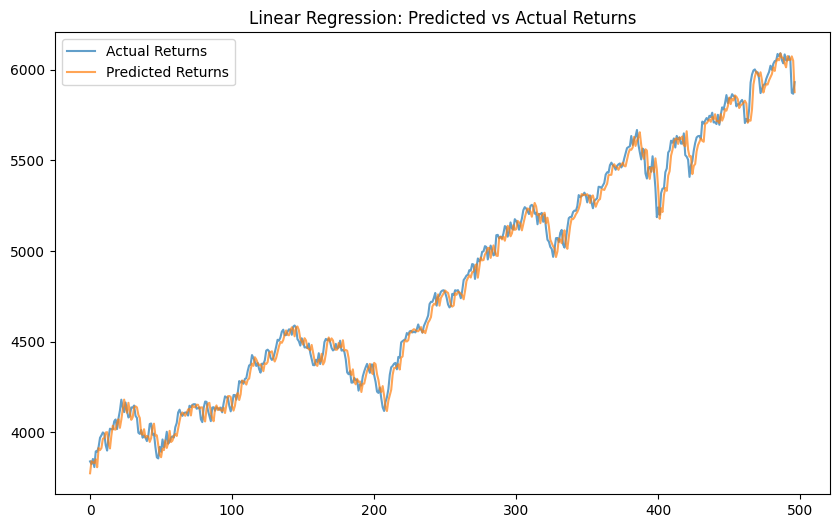

In [57]:
# Create target: next day's return
df["Target"] = df["S&P500"].shift(-1)

# Create lag features (past 30 days returns)
for lag in range(1, 31):
    df[f"lag_{lag}"] = df["S&P500"].shift(lag)

# Drop missing rows
df = df.dropna().reset_index(drop=True)

X = df[[f"lag_{i}" for i in range(1, 31)]]
y = df["Target"]

# Train/test split (time series)
split = int(0.8 * len(df))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Plot Predictions vs Actual
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual Returns", alpha=0.7)
plt.plot(y_pred, label="Predicted Returns", alpha=0.7)
plt.legend()
plt.title("Linear Regression: Predicted vs Actual Returns")
plt.show()

## Logistic Regression

In [58]:
# Create binary 
df["Target"] = (df["Return"].shift(-1) > 0).astype(int)

# Create lag features (past alpha days)
alpha=30
for lag in range(1, alpha):
    df[f"lag_{lag}"] = df["Return"].shift(lag)

# Drop rows with NaN due to lags
df = df.dropna().reset_index(drop=True)

In [59]:
# Prepare train/test sets
X = df[[f"lag_{i}" for i in range(1, alpha)]]
y = df["Target"]

# Time series split: train on first 80%, test on last 20%
split = int(0.8 * len(df))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Logistic Regression
model = LogisticRegression(class_weight='balanced',max_iter=100)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5314401622718052

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.53      0.50       217
           1       0.59      0.53      0.56       276

    accuracy                           0.53       493
   macro avg       0.53      0.53      0.53       493
weighted avg       0.54      0.53      0.53       493



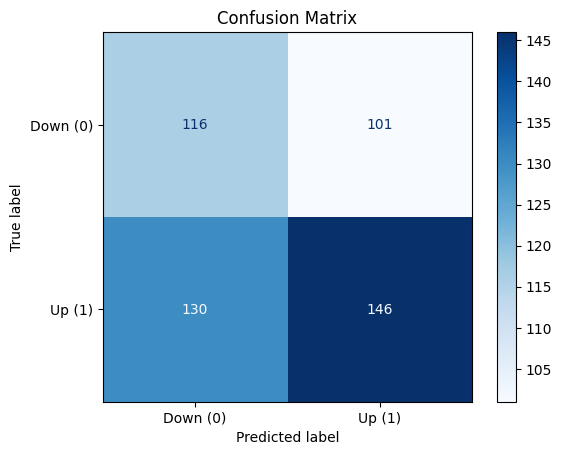

In [60]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.show()

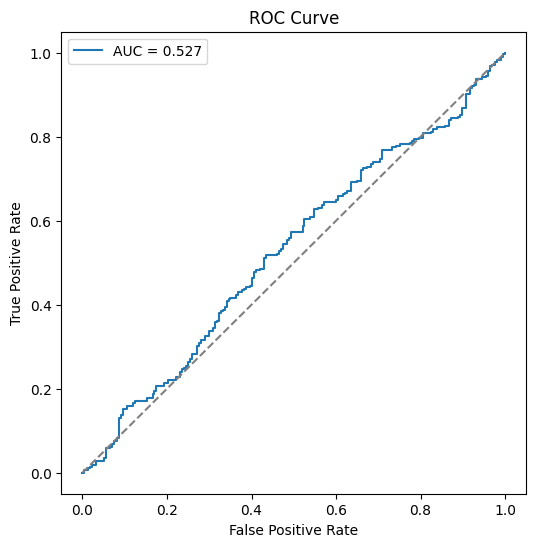

In [61]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Trees-Based Model: Regression vs. Classification

## 1. What Is a Decision Tree?
A **decision tree** recursively partitions the feature space into axis-aligned regions and assigns a constant prediction within each region (leaf).

Given training data $\{(x_i, y_i)\}_{i=1}^n$ with $x_i \in \mathbb{R}^p$, a tree builds binary splits of the form  

$$
\text{if } x_j \le \tau \text{ then go left; else go right,}
$$  

choosing $(j,\tau)$ to optimize a node-specific objective.

---

## 2. Regression Tree (Predicting Numbers)

### 2.1 Setup
Target $y \in \mathbb{R}$. For a node that contains index set $R \subset \{1,\dots,n\}$, define the node prediction as the mean:
$$
\hat{y}_R \;=\; \frac{1}{|R|}\sum_{i\in R} y_i.
$$

### 2.2 Split Criterion (Variance / MSE Reduction)
For a candidate split $(j,\tau)$ that partitions $R$ into $R_L=\{i\in R: x_{ij}\le \tau\}$ and $R_R=\{i\in R: x_{ij}>\tau\}$, the **impurity** (sum of squared errors) after the split is
$$
\mathcal{L}_{\text{reg}}(R_L,R_R)
= \sum_{i\in R_L}(y_i-\hat{y}_{R_L})^2
+ \sum_{i\in R_R}(y_i-\hat{y}_{R_R})^2.
$$
Choose $(j,\tau)$ that **minimizes** $\mathcal{L}_{\text{reg}}(R_L,R_R)$.

### 2.3 Leaf Prediction
For any $x$ that falls into leaf $R_m$, the prediction is
$$
\hat{f}(x) \;=\; \hat{y}_{R_m}.
$$

---

## 3. Classification Tree (Predicting Categories)

### 3.1 Setup
Target $y \in \{1,\dots,K\}$. In a node $R$, define class proportions
$$
\hat{p}_k(R) \;=\; \frac{1}{|R|}\sum_{i\in R}\mathbf{1}\{y_i=k\},\quad k=1,\dots,K.
$$

### 3.2 Impurity Measures
Common node impurities $I(R)$:

- **Gini**:
  $$
  I_{\text{Gini}}(R) \;=\; \sum_{k=1}^K \hat{p}_k(R)\,\bigl(1-\hat{p}_k(R)\bigr)
  \;=\; 1 - \sum_{k=1}^K \hat{p}_k(R)^2.
  $$

- **Entropy**:
  $$
  I_{\text{Ent}}(R) \;=\; -\sum_{k=1}^K \hat{p}_k(R)\,\log \hat{p}_k(R).
  $$

- **Misclassification Error**:
  $$
  I_{\text{Err}}(R) \;=\; 1 - \max_k \hat{p}_k(R).
  $$

For a candidate split $R \to (R_L,R_R)$, the **weighted impurity** is
$$
\mathcal{L}_{\text{cls}}(R_L,R_R) \;=\;
\frac{|R_L|}{|R|} I(R_L) + \frac{|R_R|}{|R|} I(R_R).
$$
Choose $(j,\tau)$ that **minimizes** $\mathcal{L}_{\text{cls}}(R_L,R_R)$.

### 3.3 Leaf Prediction
Predict the **majority class** (or report class probabilities):
$$
\hat{y}(x) \;=\; \arg\max_{k} \hat{p}_k(R_m),
\qquad
\mathbb{P}(y=k\mid x\in R_m) \approx \hat{p}_k(R_m).
$$

---

## 4. Stopping and Pruning

- **Stopping rules** (during growth): minimum samples per leaf, maximum depth, minimum impurity decrease.
- **Cost-Complexity Pruning**: choose subtree $T$ that minimizes
$$
\text{Risk}_\alpha(T) \;=\; \sum_{m \in \text{leaves}(T)} \text{Impurity}(R_m) \;+\; \alpha\,|\text{leaves}(T)|,
$$
with $\alpha \ge 0$ controlling the size–fit tradeoff.

---

## 5. Metrics

### 5.1 Regression
- **MSE**: $$ \text{MSE} = \frac{1}{n}\sum_{i=1}^n \bigl(y_i-\hat{f}(x_i)\bigr)^2. $$
- **MAE**: $$ \text{MAE} = \frac{1}{n}\sum_{i=1}^n \bigl|y_i-\hat{f}(x_i)\bigr|. $$
- **$R^2$**: $$ R^2 = 1 - \frac{\sum_i (y_i-\hat{f}(x_i))^2}{\sum_i (y_i-\bar{y})^2}. $$

### 5.2 Classification
- **Accuracy**: $$ \text{Accuracy} = \frac{1}{n}\sum_{i=1}^n \mathbf{1}\{\hat{y}_i=y_i\}. $$
- **Precision/Recall/F$_1$** (binary, positive class $1$):
  $$
  \text{Precision}=\frac{\text{TP}}{\text{TP}+\text{FP}},\quad
  \text{Recall}=\frac{\text{TP}}{\text{TP}+\text{FN}},\quad
  F_1=\frac{2\,\text{Precision}\cdot\text{Recall}}{\text{Precision}+\text{Recall}}.
  $$
- **ROC–AUC**: probability a randomly chosen positive scores higher than a randomly chosen negative.

---



## 6. Key Differences (Mathematically)

| Aspect | Regression Tree | Classification Tree |
|:--|:--|:--|
| Target | $y\in\mathbb{R}$ | $y\in\{1,\dots,K\}$ |
| Node Objective | Minimize $\sum (y-\bar{y})^2$ | Minimize $I(R)$ (Gini/Entropy/Error) |
| Leaf Output | Constant mean $\hat{y}_R$ | Majority class / $\hat{p}_k(R)$ |
| Loss at Split | SSE / MSE | Weighted impurity |

---

## 7. Bias–Variance Considerations

- Deep (unpruned) trees have **low bias, high variance**.
- Pruning / depth limits / ensembles (bagging, Random Forests, Boosting) reduce variance and improve generalization.


=== REGRESSION: Predict next-day price P_{t+1} ===

Decision Tree (Reg)
MSE: 270775.542987
R^2: 0.324474

Random Forest (Reg)
MSE: 300242.806621
R^2: 0.250959

Gradient Boosting (Reg)
MSE: 370358.854834
R^2: 0.076035


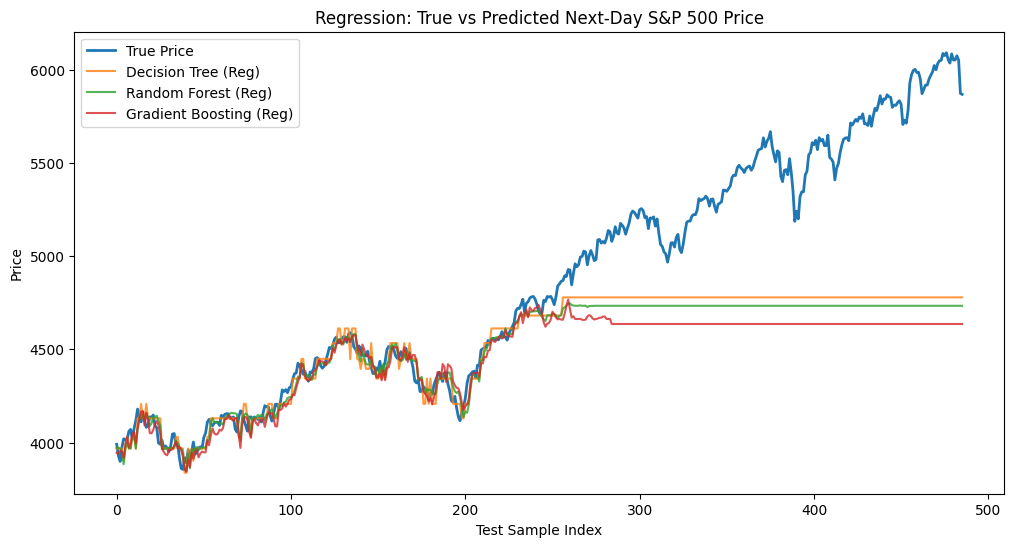


=== CLASSIFICATION: Predict direction 1{P_{t+1} > P_t} ===

Decision Tree (Cls)
Accuracy: 0.5473
ROC-AUC:  0.5084
Confusion Matrix:
[[  5 210]
 [ 10 261]]
              precision    recall  f1-score   support

           0      0.333     0.023     0.043       215
           1      0.554     0.963     0.704       271

    accuracy                          0.547       486
   macro avg      0.444     0.493     0.373       486
weighted avg      0.456     0.547     0.412       486


Random Forest (Cls)
Accuracy: 0.4753
ROC-AUC:  0.4978
Confusion Matrix:
[[168  47]
 [208  63]]
              precision    recall  f1-score   support

           0      0.447     0.781     0.569       215
           1      0.573     0.232     0.331       271

    accuracy                          0.475       486
   macro avg      0.510     0.507     0.450       486
weighted avg      0.517     0.475     0.436       486


Gradient Boosting (Cls)
Accuracy: 0.5473
ROC-AUC:  0.5018
Confusion Matrix:
[[ 74 141]
 [ 79 

<Figure size 800x600 with 0 Axes>

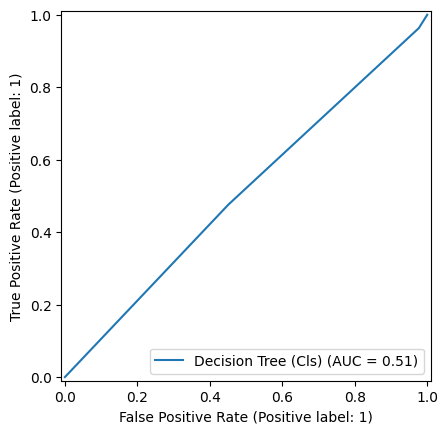

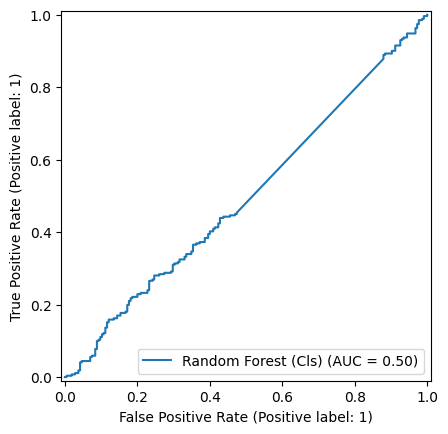

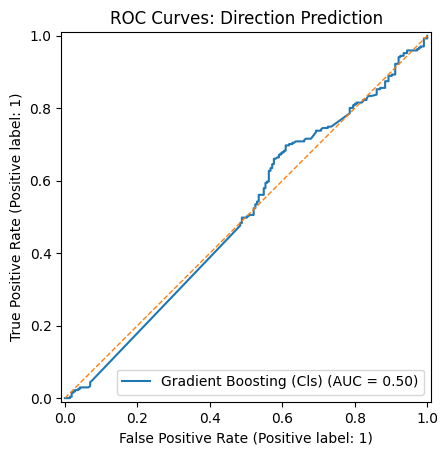


=== Baselines ===
Regression baseline (Naive P_{t+1}=P_t):
MSE: 3196.462391
R^2: 0.992026

Classification baseline (predict majority class):
Accuracy: 0.5576
Confusion Matrix:
[[  0 215]
 [  0 271]]


In [62]:
prices = df["S&P500"].astype(float).values

# Build features: past 30 prices
#    X_t = (P_{t-29},...,P_t); targets:
#    - Regression: y_reg = P_{t+1}
#    - Classification: y_cls = 1{P_{t+1} > P_t}
window = 30
X, y_reg, y_cls = [], [], []

for t in range(window, len(prices)-1):
    X.append(prices[t-window:t])
    y_reg.append(prices[t+1])
    y_cls.append(1 if prices[t+1] > prices[t] else 0)

X = np.array(X)
y_reg = np.array(y_reg)
y_cls = np.array(y_cls)

# Time-ordered split (no shuffle)
X_train, X_test, yreg_train, yreg_test, ycls_train, ycls_test = train_test_split(
    X, y_reg, y_cls, test_size=0.2, shuffle=False
)

# Define models
models_reg = {
    "Decision Tree (Reg)": DecisionTreeRegressor(max_depth=6, random_state=42),
    "Random Forest (Reg)": RandomForestRegressor(n_estimators=300, max_depth=6, random_state=42, n_jobs=-1),
    "Gradient Boosting (Reg)": GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
}

models_cls = {
    "Decision Tree (Cls)": DecisionTreeClassifier(max_depth=6, random_state=42),
    "Random Forest (Cls)": RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42, n_jobs=-1),
    "Gradient Boosting (Cls)": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
}

# REGRESSION
print("=== REGRESSION: Predict next-day price P_{t+1} ===")
reg_preds = {}
for name, model in models_reg.items():
    model.fit(X_train, yreg_train)
    yp = model.predict(X_test)
    reg_preds[name] = yp
    mse = mean_squared_error(yreg_test, yp)
    r2 = r2_score(yreg_test, yp)
    print(f"\n{name}")
    print(f"MSE: {mse:.6f}")
    print(f"R^2: {r2:.6f}")

# Plot true vs predictions
plt.figure(figsize=(12,6))
plt.plot(yreg_test, label="True Price", linewidth=2)
for name, yp in reg_preds.items():
    plt.plot(yp, label=name, alpha=0.8)
plt.title("Regression: True vs Predicted Next-Day S&P 500 Price")
plt.xlabel("Test Sample Index")
plt.ylabel("Price")
plt.legend()
plt.show()

# CLASSIFICATION: Fit & evaluate (direction)
print("\n=== CLASSIFICATION: Predict direction 1{P_{t+1} > P_t} ===")
cls_probs = {}
cls_preds = {}
for name, model in models_cls.items():
    model.fit(X_train, ycls_train)
    yhat = model.predict(X_test)
    cls_preds[name] = yhat

    # Some classifiers have predict_proba, GradientBoostingClassifier does.
    if hasattr(model, "predict_proba"):
        yproba = model.predict_proba(X_test)[:, 1]
    else:
        # fallback: decision_function if available, else cast predictions
        if hasattr(model, "decision_function"):
            # map scores to [0,1] via a simple rank-based transform (not calibrated)
            raw = model.decision_function(X_test)
            # normalize to 0-1
            yproba = (raw - raw.min()) / (raw.max() - raw.min() + 1e-12)
        else:
            yproba = yhat.astype(float)

    cls_probs[name] = yproba

    acc = accuracy_score(ycls_test, yhat)
    auc = roc_auc_score(ycls_test, yproba)
    cm = confusion_matrix(ycls_test, yhat)

    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC:  {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print(classification_report(ycls_test, yhat, digits=3))

# ROC curves
plt.figure(figsize=(8,6))
for name, proba in cls_probs.items():
    RocCurveDisplay.from_predictions(ycls_test, proba, name=name)
plt.title("ROC Curves: Direction Prediction")
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.show()

# Simple sanity baselines for comparison
# Regression baseline: "naive" next price equals today's price
yreg_naive = X_test[:, -1]  # today's price P_t
print("\n=== Baselines ===")
print("Regression baseline (Naive P_{t+1}=P_t):")
print(f"MSE: {mean_squared_error(yreg_test, yreg_naive):.6f}")
print(f"R^2: {r2_score(yreg_test, yreg_naive):.6f}")

# Classification baseline: majority class in training set
maj = int(np.round(ycls_train.mean()))  # 0 or 1
ycls_maj = np.full_like(ycls_test, maj)
print("\nClassification baseline (predict majority class):")
print(f"Accuracy: {accuracy_score(ycls_test, ycls_maj):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(ycls_test, ycls_maj))

## Why Classification Models Perform Poorly in Return Direction Prediction

Predicting whether the next return will be **positive (up)** or **negative (down)** 
is a classification task. However, classification models often perform poorly in this setting.  

---

### 1. Financial Returns Are Close to a Random Walk
- According to the **Efficient Market Hypothesis (EMH)**, past prices contain little predictive information.  
- Daily returns are nearly i.i.d. noise with very low autocorrelation.  
- The **signal-to-noise ratio** is extremely small, so classification models struggle to learn.  

---

### 2. Class Imbalance & Small Predictability
- Stock markets tend to go up more often than down due to the **equity risk premium**.  
- For example, if  
$$
P(\text{up}) \approx 0.55, \quad P(\text{down}) \approx 0.45,
$$
then a naive classifier that always predicts "up" already achieves ~55% accuracy.  
- A machine learning model may not improve much beyond this baseline.

---

### 3. Weak Features
- Using only **past returns** as predictors provides very little information.  
- Market direction depends on additional factors:  
  - Macroeconomic variables  
  - Volatility regimes  
  - Sentiment and order flow  
- Without strong features, classification fails to separate "up" vs "down."  

---

### 4. Noise Dominates Signal
- Small predictable components (momentum, mean reversion) are overwhelmed by **random shocks**.  
- Example: even if  
$$
E[R_{t+1} \mid R_t] > 0,
$$ 
the variance of returns is so large that the conditional mean is barely detectable.  

---

### 5. Misleading Evaluation Metrics
- **Accuracy** is not always informative.  
- A model with 52% accuracy may look weak, but in trading this small edge can be valuable.  
- Better metrics:  
  - Precision/recall for downside prediction  
  - Sharpe ratio of trading strategy  

---

### 6. Nonstationarity & Regime Shifts
- The relationship between predictors and returns changes over time.  
- A model trained on one regime (e.g., pre-crisis) may fail in another (e.g., post-crisis).  

---

### 7. Logistic Regression Limitations
- Logistic regression assumes linear separability:  
$$
P(Y=1 \mid X) = \frac{1}{1 + e^{-(\beta_0 + \beta^T X)}}
$$  
- Financial data is highly **nonlinear** and **non-Gaussian**, so linear boundaries miss important structure.  
- Tree-based or neural models can capture more complexity, but noise still limits predictability.  

---

# Unsupervised Learning in Finance

Unsupervised learning in finance is about uncovering hidden structures or patterns in financial data 
**without predefined labels or target variables**. 
Instead of predicting an outcome (such as "will the stock go up tomorrow?"), 
the goal is to **group, compress, or detect structure** in noisy, high-dimensional financial data.  

---

## Applications of Unsupervised Learning in Finance

### 1. Clustering
- **Portfolio diversification**: Group stocks with similar return profiles or risk exposures 
  (e.g., *k*-means, hierarchical clustering).
- **Market segmentation**: Identify different types of investors, customers, or trading behaviors.
- **Fraud detection**: Cluster transaction behaviors and flag outliers.

### 2. Dimensionality Reduction
- **Factor discovery**: Use PCA (Principal Component Analysis) or ICA 
  to extract latent risk factors beyond CAPM or Fama–French.
- **Visualization**: Reduce thousands of features (returns, macro indicators) into 2--3 dimensions 
  for exploratory analysis.

### 3. Anomaly Detection
- **Fraud detection**: Identify suspicious trades or money-laundering activities.
- **Outlier returns**: Spot unusual asset moves (e.g., flash crashes).  
  Methods: one-class SVM, autoencoders, isolation forests.

### 4. Representation Learning
- **Embedding securities**: Learn vector representations of assets from historical price series.
- **Market regimes**: Use clustering or autoencoders to identify 
  "bull," "bear," or "crisis" regimes in markets.

### 5. Generative Models
- **Synthetic data generation**: GANs or VAEs to create artificial return series 
  for stress testing or option pricing.
- **Scenario analysis**: Generate rare but plausible risk scenarios.

---

## Common Algorithms in Finance

- **Clustering**: *k*-means, Gaussian Mixture Models, hierarchical clustering, spectral clustering.  
- **Dimensionality reduction**: PCA, ICA, t-SNE, autoencoders.  
- **Anomaly detection**: Isolation forest, one-class SVM, deep autoencoders.  
- **Manifold learning**: UMAP, diffusion maps for market structure discovery.  

In short:  
**Unsupervised learning in finance helps find hidden structures, detect anomalies, 
and reduce complexity — without needing labeled outcomes.**


## Assignment: 
(Optional, if you finish this part, please send to me by Teams or email)
* Change a Loss Function for Linear Regression Logistic Regression to re-generate the plots. (Check Documentation, you will only need to change a parameter value)
* Right now, we are doing Future <b>Price </b> prediction, change the code to predict the return and re-generate the plots.

## Reading Material Three (Mandatory)

We now have results from our models and a basic understanding of their application scenarios.  
However, we also observed that not every model performed well. This leads us to the next step: **model tuning**.  

In the first part of next week’s reading, we will focus on learning how to tune models to improve their performance.  
After that, we will explore the concept of **training** in machine learning.  
Specifically, we will dive into how a computer learns the underlying features of the data during the training process.
